# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html

In [1]:
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test',
                      download=True,
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [37]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
)
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [40]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        scheduler.step()
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    acc_history = []
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!

    for i_step, (x, y) in enumerate(loader):
        pred_prob = model(x)
        pred_labels = pred_prob.argmax(dim=1)
        accuracy = sum([1 for pred, test in zip(pred_labels, y) if pred == test]) / batch_size
        acc_history.append(accuracy)

    return np.mean(acc_history)

In [41]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.435357, Train accuracy: 0.594530, Val accuracy: 0.616130
Average loss: 1.369090, Train accuracy: 0.625823, Val accuracy: 0.636053
Average loss: 1.337707, Train accuracy: 0.646760, Val accuracy: 0.646971


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [55]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(3*32*32, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 10),
)
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.174767, Train accuracy: 0.200901, Val accuracy: 0.231100
Average loss: 1.980397, Train accuracy: 0.294356, Val accuracy: 0.343272
Average loss: 1.772308, Train accuracy: 0.393765, Val accuracy: 0.406932
Average loss: 1.695513, Train accuracy: 0.424018, Val accuracy: 0.429449
Average loss: 1.671221, Train accuracy: 0.438334, Val accuracy: 0.442344


Добавьте слой с Batch Normalization

In [54]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 1024),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(1024),

    nn.Linear(1024, 100),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(100),

    nn.Linear(100, 10),
)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.492953, Train accuracy: 0.560915, Val accuracy: 0.620838
Average loss: 1.364222, Train accuracy: 0.637836, Val accuracy: 0.625614
Average loss: 1.408821, Train accuracy: 0.647596, Val accuracy: 0.617563
Average loss: 1.427665, Train accuracy: 0.645207, Val accuracy: 0.678766
Average loss: 1.442388, Train accuracy: 0.641760, Val accuracy: 0.591635


Добавьте уменьшение скорости обучения по ходу тренировки.

In [11]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 1024),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(1024),

    nn.Linear(1024, 100),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(100),

    nn.Linear(100, 10),
)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.305489, Train accuracy: 0.596526, Val accuracy: 0.713701
Average loss: 0.899520, Train accuracy: 0.724312, Val accuracy: 0.729735
Average loss: 0.696255, Train accuracy: 0.788605, Val accuracy: 0.779817
Average loss: 0.641104, Train accuracy: 0.806573, Val accuracy: 0.788960
Average loss: 0.541891, Train accuracy: 0.836126, Val accuracy: 0.819733


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [111]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)

    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!

    sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=sampler)

    predictions = []
    ground_truth = []

    for i_step, (x, y) in enumerate(loader):    # get a batch with size 64 - 64*229=14656
        pred_prob = model(x)
        pred_labels = pred_prob.argmax(dim=1)
        predictions.extend(pred_labels)
        ground_truth.extend(y)

    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

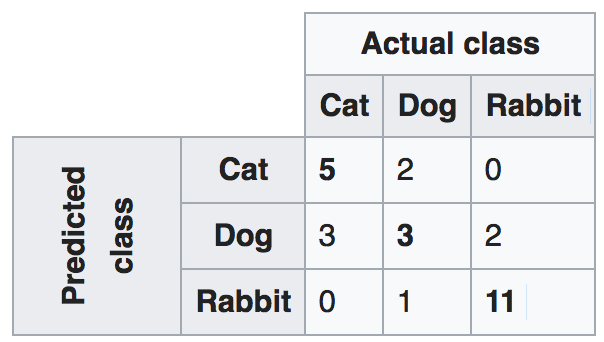

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

C:\Users\merkulov\AppData\Local\Temp/ipykernel_11812/2978584929.py:37: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  confusion_matrix = np.zeros((10, 10), np.int)


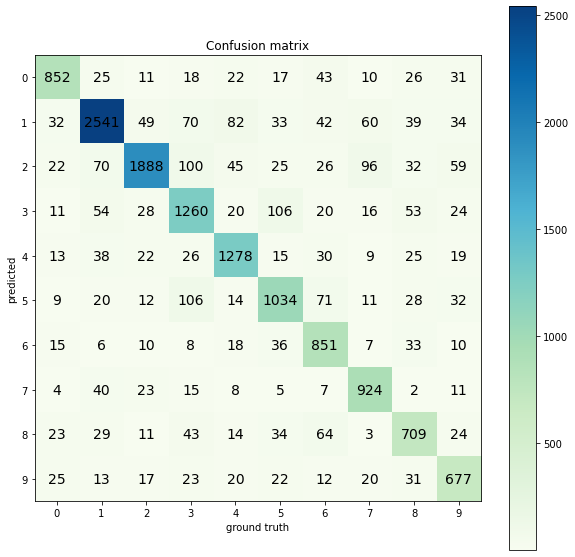

In [112]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10, 10), np.int)

    # TODO: Implement filling the prediction matrix
    for i, row in enumerate(confusion_matrix):    # i = prediction
        for j, value in enumerate(row):    # j = gt
            confusion_matrix[i][j] = sum([1 for pred, gt in zip(predictions, ground_truth) if pred == i and gt == j])

    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

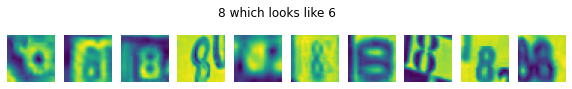

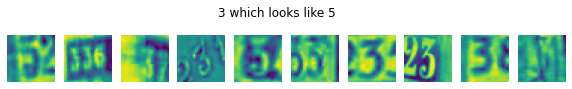

In [132]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, ground_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!

    val_data = data.data[val_indices]
    indices = [idx for idx, (pred, gt) in enumerate(zip(predictions,ground_truth)) if pred == predicted_class and gt == gt_class]
    visualize_images(indices, val_data, title=f'{gt_class} which looks like {predicted_class}')

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(5, 3, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [61]:
# hyperparameters search
import optuna

num_epochs = 3

def objective(trial):
    lr = trial.suggest_float('learning rate', 1e-4, 1e-1, log=True)
    optimizer = trial.suggest_categorical('optimizer', (optim.SGD, optim.Adam))

    nn_model = create_model(trial)
    optimizer = optimizer(nn_model.parameters(), lr=lr)

    print(nn_model)
    loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, num_epochs)

    return val_history[-1]

def create_model(trial):
    in_size = 3*32*32
    n_layers = trial.suggest_int('n_layers', 1, 4)
    activation = trial.suggest_categorical('activation', (nn.ReLU, nn.Sigmoid))
    has_batch_norm = trial.suggest_categorical('batch normalization', (True, False))

    layers = [Flattener()]
    for i in range(n_layers):
        n_units = trial.suggest_int(rf'n_units_l{i}', 32, in_size)
        layers.append(nn.Linear(in_size, n_units))
        layers.append(activation())
        if has_batch_norm:
            layers.append(nn.BatchNorm1d(n_units))
        in_size = n_units
    layers.append(nn.Linear(in_size, 10, bias=False))

    return nn.Sequential(*layers)

pruner = optuna.pruners.ThresholdPruner(lower=0.65)
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=10)

[I 2021-07-12 13:36:23,523] A new study created in memory with name: no-name-fa3eb71f-455b-407c-93b6-d879478ac185


Sequential(
  (0): Flattener()
  (1): Linear(in_features=3072, out_features=2074, bias=True)
  (2): Sigmoid()
  (3): BatchNorm1d(2074, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=2074, out_features=1057, bias=True)
  (5): Sigmoid()
  (6): BatchNorm1d(1057, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Linear(in_features=1057, out_features=260, bias=True)
  (8): Sigmoid()
  (9): BatchNorm1d(260, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Linear(in_features=260, out_features=10, bias=False)
)
Average loss: 2.235372, Train accuracy: 0.214961, Val accuracy: 0.261531
Average loss: 2.075721, Train accuracy: 0.301812, Val accuracy: 0.384211


[I 2021-07-12 13:41:30,258] Trial 0 finished with value: 0.4585152838427948 and parameters: {'learning rate': 0.025171973088258033, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'n_layers': 3, 'activation': <class 'torch.nn.modules.activation.Sigmoid'>, 'batch normalization': True, 'n_units_l0': 2074, 'n_units_l1': 1057, 'n_units_l2': 260}. Best is trial 0 with value: 0.4585152838427948.


Average loss: 1.845350, Train accuracy: 0.420094, Val accuracy: 0.458515
Sequential(
  (0): Flattener()
  (1): Linear(in_features=3072, out_features=2037, bias=True)
  (2): Sigmoid()
  (3): BatchNorm1d(2037, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=2037, out_features=178, bias=True)
  (5): Sigmoid()
  (6): BatchNorm1d(178, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Linear(in_features=178, out_features=10, bias=False)
)
Average loss: 2.292027, Train accuracy: 0.175443, Val accuracy: 0.132574
Average loss: 2.266646, Train accuracy: 0.173617, Val accuracy: 0.173649


[I 2021-07-12 13:48:26,973] Trial 1 finished with value: 0.18797762008733623 and parameters: {'learning rate': 0.04780919607876103, 'optimizer': <class 'torch.optim.adam.Adam'>, 'n_layers': 2, 'activation': <class 'torch.nn.modules.activation.Sigmoid'>, 'batch normalization': True, 'n_units_l0': 2037, 'n_units_l1': 178}. Best is trial 0 with value: 0.4585152838427948.


Average loss: 2.246394, Train accuracy: 0.184111, Val accuracy: 0.187978
Sequential(
  (0): Flattener()
  (1): Linear(in_features=3072, out_features=1930, bias=True)
  (2): ReLU()
  (3): BatchNorm1d(1930, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=1930, out_features=33, bias=True)
  (5): ReLU()
  (6): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Linear(in_features=33, out_features=32, bias=True)
  (8): ReLU()
  (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Linear(in_features=32, out_features=10, bias=False)
)
Average loss: 1.478199, Train accuracy: 0.497594, Val accuracy: 0.630459
Average loss: 1.031641, Train accuracy: 0.673754, Val accuracy: 0.721343


[I 2021-07-12 13:54:08,715] Trial 2 finished with value: 0.7693777292576419 and parameters: {'learning rate': 0.005177947527176833, 'optimizer': <class 'torch.optim.adam.Adam'>, 'n_layers': 3, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'batch normalization': True, 'n_units_l0': 1930, 'n_units_l1': 33, 'n_units_l2': 32}. Best is trial 2 with value: 0.7693777292576419.


Average loss: 0.829481, Train accuracy: 0.739822, Val accuracy: 0.769378
Sequential(
  (0): Flattener()
  (1): Linear(in_features=3072, out_features=2251, bias=True)
  (2): ReLU()
  (3): Linear(in_features=2251, out_features=10, bias=False)
)
Average loss: 4081.937500, Train accuracy: 0.392229, Val accuracy: 0.547762
Average loss: 3382.950928, Train accuracy: 0.567382, Val accuracy: 0.630254


[I 2021-07-12 13:59:45,292] Trial 3 finished with value: 0.71492903930131 and parameters: {'learning rate': 0.09453407910982532, 'optimizer': <class 'torch.optim.adam.Adam'>, 'n_layers': 1, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'batch normalization': False, 'n_units_l0': 2251}. Best is trial 2 with value: 0.7693777292576419.


Average loss: 1036.697754, Train accuracy: 0.730232, Val accuracy: 0.714929
Sequential(
  (0): Flattener()
  (1): Linear(in_features=3072, out_features=1570, bias=True)
  (2): ReLU()
  (3): BatchNorm1d(1570, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=1570, out_features=332, bias=True)
  (5): ReLU()
  (6): BatchNorm1d(332, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Linear(in_features=332, out_features=223, bias=True)
  (8): ReLU()
  (9): BatchNorm1d(223, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Linear(in_features=223, out_features=10, bias=False)
)
Average loss: 1.264002, Train accuracy: 0.590383, Val accuracy: 0.701760
Average loss: 0.867798, Train accuracy: 0.726939, Val accuracy: 0.763237


[I 2021-07-12 14:04:46,829] Trial 4 finished with value: 0.7972161572052402 and parameters: {'learning rate': 0.0003988984667861665, 'optimizer': <class 'torch.optim.adam.Adam'>, 'n_layers': 3, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'batch normalization': True, 'n_units_l0': 1570, 'n_units_l1': 332, 'n_units_l2': 223}. Best is trial 4 with value: 0.7972161572052402.


Average loss: 0.670188, Train accuracy: 0.790977, Val accuracy: 0.797216
Sequential(
  (0): Flattener()
  (1): Linear(in_features=3072, out_features=1400, bias=True)
  (2): ReLU()
  (3): BatchNorm1d(1400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=1400, out_features=495, bias=True)
  (5): ReLU()
  (6): BatchNorm1d(495, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Linear(in_features=495, out_features=147, bias=True)
  (8): ReLU()
  (9): BatchNorm1d(147, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Linear(in_features=147, out_features=10, bias=False)
)
Average loss: 1.246831, Train accuracy: 0.603437, Val accuracy: 0.718204
Average loss: 0.859415, Train accuracy: 0.729772, Val accuracy: 0.751228


[I 2021-07-12 14:09:45,763] Trial 5 finished with value: 0.804721615720524 and parameters: {'learning rate': 0.00026708677657642094, 'optimizer': <class 'torch.optim.adam.Adam'>, 'n_layers': 3, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'batch normalization': True, 'n_units_l0': 1400, 'n_units_l1': 495, 'n_units_l2': 147}. Best is trial 5 with value: 0.804721615720524.


Average loss: 0.657417, Train accuracy: 0.794117, Val accuracy: 0.804722
Sequential(
  (0): Flattener()
  (1): Linear(in_features=3072, out_features=2023, bias=True)
  (2): ReLU()
  (3): BatchNorm1d(2023, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=2023, out_features=10, bias=False)
)
Average loss: 2.227450, Train accuracy: 0.205679, Val accuracy: 0.319187
Average loss: 2.002241, Train accuracy: 0.368188, Val accuracy: 0.433611


[I 2021-07-12 14:13:25,385] Trial 6 finished with value: 0.4664301310043668 and parameters: {'learning rate': 0.00014145506644240956, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'n_layers': 1, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'batch normalization': True, 'n_units_l0': 2023}. Best is trial 5 with value: 0.804721615720524.


Average loss: 1.876765, Train accuracy: 0.440177, Val accuracy: 0.466430
Sequential(
  (0): Flattener()
  (1): Linear(in_features=3072, out_features=1602, bias=True)
  (2): Sigmoid()
  (3): BatchNorm1d(1602, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=1602, out_features=1235, bias=True)
  (5): Sigmoid()
  (6): BatchNorm1d(1235, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Linear(in_features=1235, out_features=10, bias=False)
)
Average loss: 2.283749, Train accuracy: 0.185629, Val accuracy: 0.232465
Average loss: 2.231642, Train accuracy: 0.236853, Val accuracy: 0.246247


[I 2021-07-12 14:17:45,736] Trial 7 finished with value: 0.2592112445414847 and parameters: {'learning rate': 0.00038139349269796413, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'n_layers': 2, 'activation': <class 'torch.nn.modules.activation.Sigmoid'>, 'batch normalization': True, 'n_units_l0': 1602, 'n_units_l1': 1235}. Best is trial 5 with value: 0.804721615720524.


Average loss: 2.213995, Train accuracy: 0.253711, Val accuracy: 0.259211
Sequential(
  (0): Flattener()
  (1): Linear(in_features=3072, out_features=1015, bias=True)
  (2): Sigmoid()
  (3): BatchNorm1d(1015, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=1015, out_features=922, bias=True)
  (5): Sigmoid()
  (6): BatchNorm1d(922, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Linear(in_features=922, out_features=513, bias=True)
  (8): Sigmoid()
  (9): BatchNorm1d(513, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Linear(in_features=513, out_features=10, bias=False)
)
Average loss: 2.235039, Train accuracy: 0.217759, Val accuracy: 0.284798
Average loss: 1.788084, Train accuracy: 0.408491, Val accuracy: 0.618450


[I 2021-07-12 14:22:41,931] Trial 8 finished with value: 0.7253684497816594 and parameters: {'learning rate': 0.00012516302374194785, 'optimizer': <class 'torch.optim.adam.Adam'>, 'n_layers': 3, 'activation': <class 'torch.nn.modules.activation.Sigmoid'>, 'batch normalization': True, 'n_units_l0': 1015, 'n_units_l1': 922, 'n_units_l2': 513}. Best is trial 5 with value: 0.804721615720524.


Average loss: 1.006641, Train accuracy: 0.688752, Val accuracy: 0.725368
Sequential(
  (0): Flattener()
  (1): Linear(in_features=3072, out_features=952, bias=True)
  (2): Sigmoid()
  (3): Linear(in_features=952, out_features=381, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=381, out_features=188, bias=True)
  (6): Sigmoid()
  (7): Linear(in_features=188, out_features=10, bias=False)
)
Average loss: 2.249290, Train accuracy: 0.176620, Val accuracy: 0.192481
Average loss: 2.237730, Train accuracy: 0.188377, Val accuracy: 0.192481


[I 2021-07-12 14:24:54,847] Trial 9 finished with value: 0.19248089519650655 and parameters: {'learning rate': 0.0004918922748552773, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'n_layers': 3, 'activation': <class 'torch.nn.modules.activation.Sigmoid'>, 'batch normalization': False, 'n_units_l0': 952, 'n_units_l1': 381, 'n_units_l2': 188}. Best is trial 5 with value: 0.804721615720524.


Average loss: 2.237505, Train accuracy: 0.188377, Val accuracy: 0.192481


In [71]:
# best NN configuration

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 1024),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(1024),

    nn.Linear(1024, 512),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(512),

    nn.Linear(512, 128),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(128),

    nn.Linear(128, 10),
)

optimizer = optim.Adam(nn_model.parameters(), lr=1e-2)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, num_epochs=8)

Average loss: 1.499318, Train accuracy: 0.485394, Val accuracy: 0.659389
Average loss: 0.974794, Train accuracy: 0.688411, Val accuracy: 0.729599
Average loss: 0.741996, Train accuracy: 0.764683, Val accuracy: 0.791144
Average loss: 0.664321, Train accuracy: 0.789578, Val accuracy: 0.798649
Average loss: 0.550295, Train accuracy: 0.827151, Val accuracy: 0.823622
Average loss: 0.506533, Train accuracy: 0.840597, Val accuracy: 0.837336
Average loss: 0.433919, Train accuracy: 0.863290, Val accuracy: 0.845115
Average loss: 0.406142, Train accuracy: 0.871651, Val accuracy: 0.844364


In [72]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8112
